# CS530 Homework 9

In [1]:
import random
import numpy as np
import pandas as pd
import pathlib as plib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import metrics
from path import Path as pth
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#### Question 1 (5 points). 

a. Use the classifiers listed in the following block to run classifications on the three datasets provided along with the homework ('dataset1.csv', 'dataset2.csv', 'dataset3.csv'). Use train-test-split and compute the AUC on the test sets.

In [2]:
def run_score_classifier(trainDescriptors, trainTarget, testDescriptors, testTarget, classifierModel):
    fitModel = classifierModel.fit(trainDescriptors, trainTarget)
    predictions = fitModel.predict_proba(testDescriptors)
    falsePositiveRate, truePositiveRate, thresholds = metrics.roc_curve(testTarget, predictions[::, 1])
    classifierAuc = metrics.auc(falsePositiveRate, truePositiveRate)
    return classifierAuc


classifiers = {
    "Nearest Neighbors": KNeighborsClassifier(3),
    "Linear SVM": SVC(kernel="linear", C=0.025, probability=True),
    "RBF SVM": SVC(gamma=2, C=1, probability=True),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis()
}


In [3]:
# Your code goes here
absPath = pth('data').abspath()
dataPath = plib.Path(absPath)
dataSets = [p for p in dataPath.iterdir() if p.is_file()]
predictionScores = pd.DataFrame({'Dataset': [], 'Classifier': [], 'Score': []})

for dataSet in dataSets:
    p = plib.Path(dataSet)
    rawData = pd.read_csv(dataSet)
    descriptors = rawData.loc[:, :'X5']
    target = rawData['y']
    trainDescriptors, testDescriptors, trainTarget, testTarget = train_test_split(descriptors, target, test_size=0.33)
    for classifier in classifiers:
        classifierAuc = run_score_classifier(trainDescriptors, trainTarget, testDescriptors, testTarget,
                                             classifiers[classifier])
        predictionScore = pd.DataFrame({'Dataset': [p.stem], 'Classifier': [classifier], 'Score': [classifierAuc]})
        predictionScores = predictionScores.append((predictionScore))

print(predictionScores)

    Dataset         Classifier     Score
0  dataset1  Nearest Neighbors  0.738971
0  dataset1         Linear SVM  0.558824
0  dataset1            RBF SVM  0.974265
0  dataset1      Decision Tree  0.841912
0  dataset1      Random Forest  0.863971
0  dataset1           AdaBoost  0.838235
0  dataset1        Naive Bayes  0.959559
0  dataset1                LDA  0.522059
0  dataset2  Nearest Neighbors  0.944444
0  dataset2         Linear SVM  0.925926
0  dataset2            RBF SVM  0.981481
0  dataset2      Decision Tree  0.811111
0  dataset2      Random Forest  0.881481
0  dataset2           AdaBoost  0.959259
0  dataset2        Naive Bayes  0.918519
0  dataset2                LDA  0.903704
0  dataset3  Nearest Neighbors  0.938492
0  dataset3         Linear SVM  0.980159
0  dataset3            RBF SVM  0.944444
0  dataset3      Decision Tree  0.869048
0  dataset3      Random Forest  0.916667
0  dataset3           AdaBoost  0.896825
0  dataset3        Naive Bayes  0.968254
0  dataset3     

b. Use a bar plot to visualize the results you get from 1a. The x-axis should be the three datasets. The y-axis should be the AUC. The color for the bars should be the different algorithms.

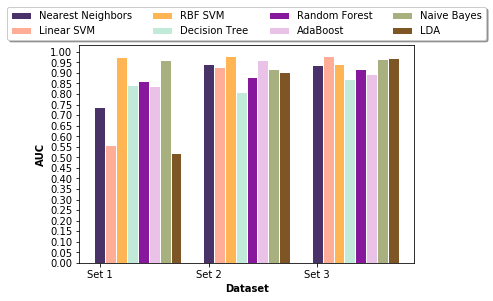

In [4]:
def plot_auc_scores(plotData, plotClassifiers, plotScores):
    barWidth = 0.1
    colors = ['#493267', '#ffad96', '#ffb554', '#c2ead8', '#87189d', '#eac2e8', '#a8b07f', '#7e5625']
    barPositionStart = np.arange(len(plotData))
    plt.xlabel('Dataset', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(plotData))], ['Set 1', 'Set 2', 'Set 3'])
    plt.yticks(np.arange(0, 1.05, step=0.05))
    plt.ylabel('AUC', fontweight='bold')

    for plotClassifier in plotClassifiers:
        classifierFilter = plotScores.Classifier == plotClassifier
        values = plotScores[classifierFilter]
        index = list(classifiers.keys()).index(plotClassifier)
        barPositions = [x + barWidth for x in barPositionStart]
        len(values)
        plt.bar(barPositions, values.Score, color=colors[index], width=barWidth, edgecolor='white',
                label=plotClassifier)
        barPositionStart = barPositions

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4, fancybox=True, shadow=True)
    plt.show()


plot_auc_scores(dataSets, classifiers, predictionScores)

#### Question 2 (5 points)

a. Perform PCA on the three datasets ('dataset1.csv', 'dataset2.csv', 'dataset3.csv'), and only keep the first 2 principal components.

In [5]:
def run_pca(descriptors, components=2):
    standardizedDescriptors = StandardScaler().fit_transform(descriptors)
    scaledPCA = PCA(n_components=components)
    scaledDescriptors = scaledPCA.fit_transform(standardizedDescriptors)
    scaledData = pd.DataFrame(data=scaledDescriptors, columns=['PC1', 'PC2'])
    return scaledData


b. Train the classifiers defined in 1a to classify on the PCA transformed data from 2a. Perform train-test-split and compute the AUC on the test sets. 

In [6]:
pcaPredictionScores = pd.DataFrame({'Dataset': [], 'Classifier': [], 'Score': []})

for dataSet in dataSets:
    p = plib.Path(dataSet)
    rawData = pd.read_csv(dataSet)
    pcaDescriptors = rawData.loc[:, :'X5']
    target = rawData['y']
    pcaDescriptors = run_pca(pcaDescriptors, 2)
    pcaTrainDescriptors, pcaTestDescriptors, pcaTrainTarget, pcaTestTarget = train_test_split(pcaDescriptors, target, test_size=0.33)
    for classifier in classifiers:
        classifierAuc = run_score_classifier(pcaTrainDescriptors, pcaTrainTarget, pcaTestDescriptors, pcaTestTarget,
                                             classifiers[classifier])
        predictionScore = pd.DataFrame({'Dataset': [p.stem], 'Classifier': [classifier], 'Score': [classifierAuc]})
        pcaPredictionScores = pcaPredictionScores.append((predictionScore))
print(pcaPredictionScores)

    Dataset         Classifier     Score
0  dataset1  Nearest Neighbors  0.362963
0  dataset1         Linear SVM  0.540741
0  dataset1            RBF SVM  0.544444
0  dataset1      Decision Tree  0.412963
0  dataset1      Random Forest  0.457407
0  dataset1           AdaBoost  0.361111
0  dataset1        Naive Bayes  0.370370
0  dataset1                LDA  0.429630
0  dataset2  Nearest Neighbors  0.803309
0  dataset2         Linear SVM  0.897059
0  dataset2            RBF SVM  0.786765
0  dataset2      Decision Tree  0.750000
0  dataset2      Random Forest  0.856618
0  dataset2           AdaBoost  0.823529
0  dataset2        Naive Bayes  0.889706
0  dataset2                LDA  0.897059
0  dataset3  Nearest Neighbors  0.723684
0  dataset3         Linear SVM  0.789474
0  dataset3            RBF SVM  0.631579
0  dataset3      Decision Tree  0.665414
0  dataset3      Random Forest  0.748120
0  dataset3           AdaBoost  0.627820
0  dataset3        Naive Bayes  0.827068
0  dataset3     

c. Use a bar plot to visualize the results you get from 2b. The x-axis should be the three datasets. The y-axis should be the AUC. The color for the bars should be the different algorithms.

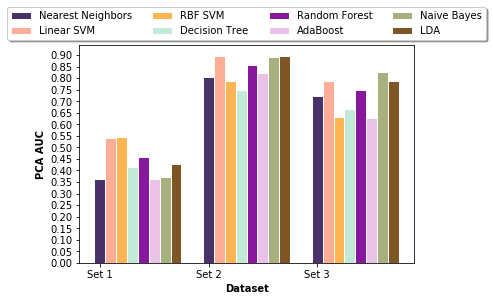

In [7]:
def plot_pca_auc_scores(plotData, plotClassifiers, plotScores):
    barWidth = 0.1
    colors = ['#493267', '#ffad96', '#ffb554', '#c2ead8', '#87189d', '#eac2e8', '#a8b07f', '#7e5625']
    barPositionStart = np.arange(len(plotData))
    plt.xlabel('Dataset', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(plotData))], ['Set 1', 'Set 2', 'Set 3'])
    plt.yticks(np.arange(0, 1.05, step=0.05))
    plt.ylabel('PCA AUC', fontweight='bold')

    for plotClassifier in plotClassifiers:
        classifierFilter = plotScores.Classifier == plotClassifier
        values = plotScores[classifierFilter]
        index = list(classifiers.keys()).index(plotClassifier)
        barPositions = [x + barWidth for x in barPositionStart]
        len(values)
        plt.bar(barPositions, values.Score, color=colors[index], width=barWidth, edgecolor='white',
                label=plotClassifier)
        barPositionStart = barPositions

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4, fancybox=True, shadow=True)
    plt.show()

plot_pca_auc_scores(dataSets, classifiers, pcaPredictionScores)

d. Use the plotting function below to visualize the decision boundary of each algorithms on each dataset. The function takes 3 inputs, clf, the classifier object, X, a two-dimensional numpy array, and y, a one-dimensional numpy array.

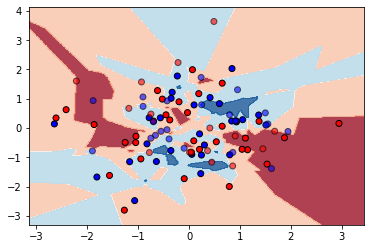

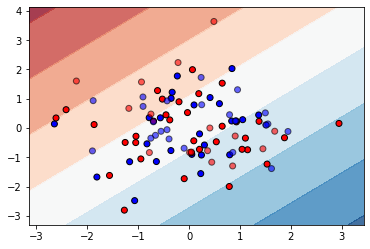

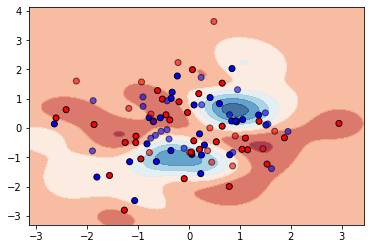

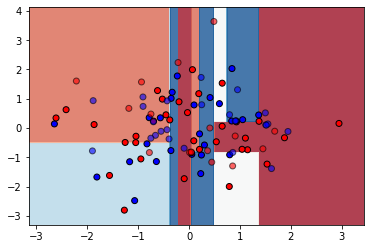

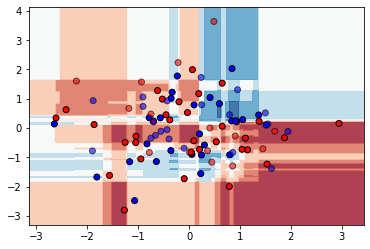

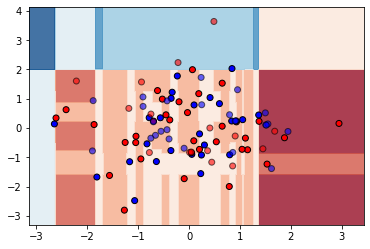

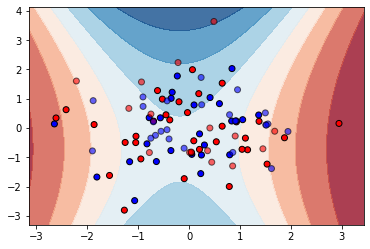

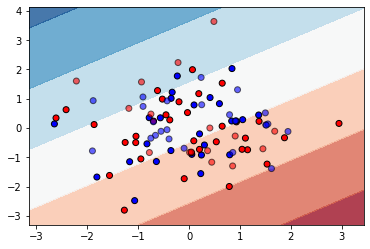

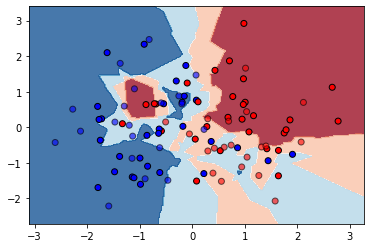

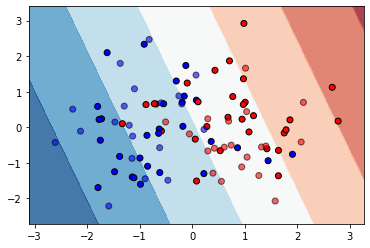

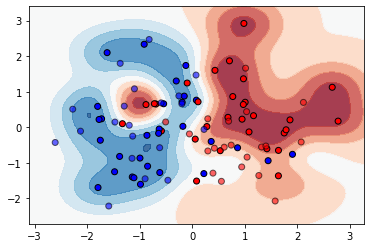

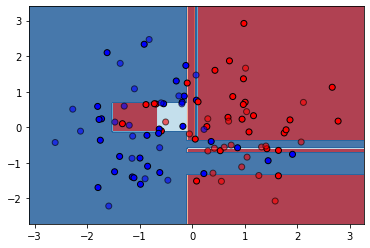

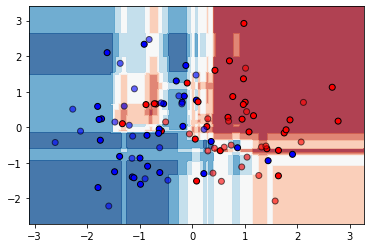

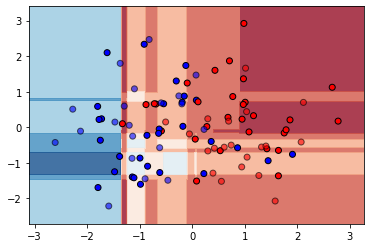

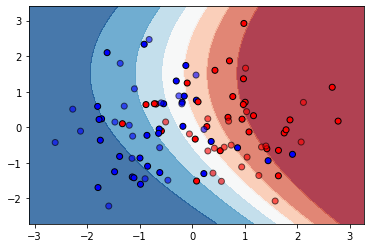

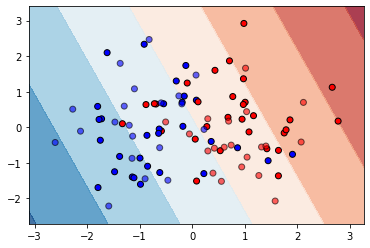

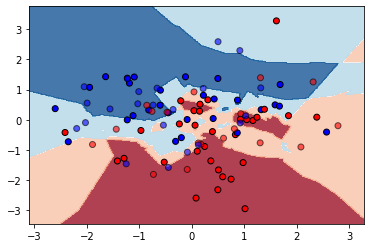

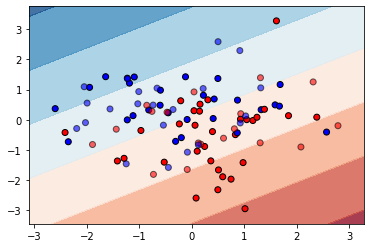

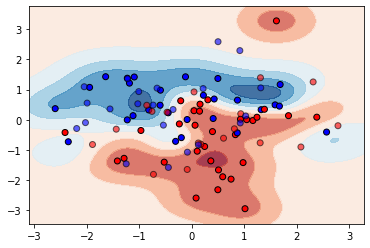

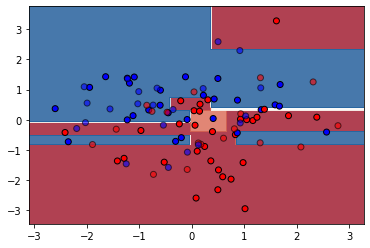

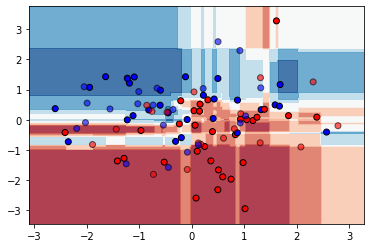

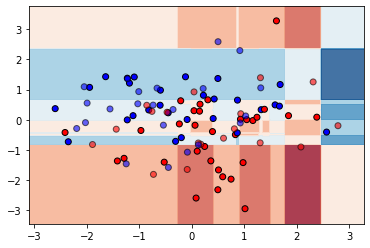

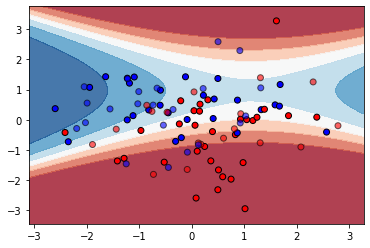

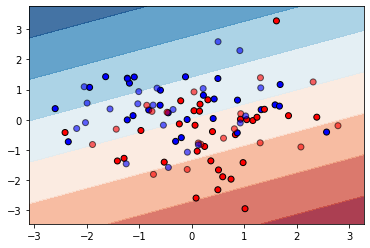

In [9]:
def plot_decision_boundary(clf, X, y): 
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    # Set up plotting mesh
    # Step size of the mesh
    h = .02 
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Perform classification
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    # Plot the decision boundary. For that, we will assign a color to each

    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot the training points
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               edgecolors='k', alpha=0.6)

for dataSet in dataSets:
    p = plib.Path(dataSet)
    rawData = pd.read_csv(dataSet)
    pcaDescriptors = rawData.loc[:, :'X5']
    target = rawData['y']
    pcaDescriptors = run_pca(pcaDescriptors, 2)
    for classifier in classifiers:
        plot_decision_boundary(classifiers[classifier], pcaDescriptors.to_numpy(), target.to_numpy())
        plt.show()